In [1]:
from ctypes import (
    CDLL, POINTER, c_char_p, c_bool, c_double, c_int,
    c_short, c_void_p, c_float, c_ushort, Structure,
    c_ulong, c_long, c_uint, c_uint64, byref, sizeof, cdll
)
from qudi.hardware.tcspc.spc_def import (
    SPCdata, SPCModInfo, SPC_EEP_Data, SPC_Adjust_Para,
    SPCMemConfig, PhotStreamInfo, PhotInfo, PhotInfo64,
    rate_values
)
import time
from qudi.hardware.tcspc.tcspc import SPCDllWrapper
import os
import matplotlib.pyplot as plt
import copy
import numpy as np

In [2]:
def initialise_tcspc(tcspc, module_no):

    ini_file_path = os.path.abspath(r'C:\EXP\python\Qoptics_exp\new_settings.ini')
    init_status, args = tcspc.SPC_init(ini_file_path)
    print(f'Init status: {init_status} with args: {args}')

    init_status, args = tcspc.SPC_get_init_status(module_no)
    print(f'Init status of module {module_no}: {init_status} with args: {args}')

    status, mode, force_use, in_use = tcspc.SPC_set_mode(0, 1, 1)
    print(f'Set mode status: {status} with mode: {mode} and force_use: {force_use} and in_use: {in_use}')

    init_status, args = tcspc.SPC_get_init_status(module_no)
    print(f'Init status of module {module_no}: {init_status} with args: {args}')

    status = tcspc.SPC_get_mode()
    print(f'Get mode status: {status}')

    status, mod_no, data = tcspc.SPC_get_parameters(module_no)
    print(f'Get parameters status: {status} with mod_no: {mod_no} and data collect time: {data.collect_time}')

    return data

def test_state(tcspc, module_no, print_status=False):

    state_var = 0
    status, mod_no, state = tcspc.SPC_test_state(module_no, state_var)
    #print(f'Test state status: {status} with mod_no: {mod_no} and state: {bytes(state)}')
    status_code = tcspc.translate_status(state)
    if print_status:
        print(f'Status code: {status_code}')

    return status_code

def empty_memory_bank(tcspc, module_no, block, page, fill_value):

    status, mod_no, block, page, fill_value = tcspc.SPC_fill_memory(module_no, block, page, fill_value)
    print(f'Fill memory status: {status} with block: {block}, page: {page} and fill_value: {fill_value}')
    continue_fill = True
    while continue_fill:
        status_code = test_state(tcspc, module_no)

        if 'SPC_HFILL_NRDY' in status_code:
            print('Memory bank not filled')
            time.sleep(1)
        else:
            continue_fill = False
            print('Memory bank filled')
    
def configure_memory(tcspc, adc_resolution, no_of_routing_bits, module_no, page_no=1):

    status, mod_no, adc_resolution, no_of_routing_bits, mem_info = tcspc.SPC_configure_memory(module_no, adc_resolution, no_of_routing_bits, SPCMemConfig())
    print(f'Configure memory status: {status} with adc_resolution: {adc_resolution}, no_of_routing_bits: {no_of_routing_bits} and mem_info: {mem_info}')

    return mem_info

In [3]:
tcspc = SPCDllWrapper()

module_no = 0

data = initialise_tcspc(tcspc, module_no)
print(data.mode)

Init status: 0 with args: C:\EXP\python\Qoptics_exp\new_settings.ini
Init status of module 0: -6 with args: c_short(0)
Set mode status: 0 with mode: c_short(0) and force_use: c_short(1) and in_use: c_long(1)
Init status of module 0: 0 with args: c_short(0)
Get mode status: (0, c_long(0))
Get parameters status: 0 with mod_no: c_short(0) and data collect time: 3.0
0


In [4]:
no_of_routing_bits = 0
adc_resolution = data.adc_resolution

status, mod_no, enable = tcspc.SPC_enable_sequencer(module_no, 0)
print(f'Enable sequencer status: {status} with mod_no: {mod_no} and enable: {enable}')

mem_info = configure_memory(tcspc, 6, no_of_routing_bits, module_no)

max_block_no = mem_info.max_block_no
max_page = mem_info.maxpage
max_curve = max_block_no / max_page
block_length = mem_info.block_length

page_size = mem_info.blocks_per_frame * mem_info.frames_per_page * block_length

print(page_size)

buffer = (c_ushort * page_size)()

measurement_page = 0
offset_value = 1

empty_memory_bank(tcspc, module_no, -1, measurement_page, offset_value)

status, mod_no, page = tcspc.SPC_set_page(module_no, measurement_page)
print(f'Set page status: {status} with mod_no: {mod_no} and page: {page}')

status, mod_no = tcspc.SPC_clear_rates(module_no)
print(f'Clear rates status: {status} with mod_no: {mod_no}')

status, mod_no, sync_state = tcspc.SPC_get_sync_state(module_no, 0)
print(f'Get sync state status: {status} with mod_no: {mod_no} and sync_state: {sync_state}')

new_time = 0.0
old_time = 0.0
disp_time = 1

red_factor = 1
var_from = 0
var_to = block_length - 1

armed = True
counter = 0

print(f'Measurement time: {data.collect_time}')
print(f'Block length: {block_length}')

Enable sequencer status: 0 with mod_no: c_short(0) and enable: c_short(0)
Configure memory status: 0 with adc_resolution: c_short(6), no_of_routing_bits: c_short(0) and mem_info: <qudi.hardware.tcspc.spc_def.SPCMemConfig object at 0x000001FE4A8386C0>
64
Fill memory status: 0 with block: c_long(-1), page: c_long(0) and fill_value: c_ushort(1)
Memory bank filled
Set page status: 0 with mod_no: c_short(0) and page: c_long(0)
Clear rates status: 0 with mod_no: c_short(0)
Get sync state status: 0 with mod_no: c_short(0) and sync_state: c_short(1)
Measurement time: 3.0
Block length: 64


In [5]:


status, mod_no = tcspc.SPC_start_measurement(module_no)
print(f'Start measurement status: {status} with mod_no: {mod_no}')

while armed:
    
    status = test_state(tcspc, module_no, True)
    if 'SPC_ARMED' not in status:
        armed = False
        print('Measurement finished')
        status, mod_no, block, page, red_factor, var_from, var_to, buffer = tcspc.SPC_read_data_block(module_no, 0, measurement_page, 1, 0, block_length - 1, buffer)
        print(f'Read memory status: {status} with mod_no: {mod_no} and buffer: {buffer}')

        print(list(buffer))

        break
    counter += 1

    pause_status, mod_no = tcspc.SPC_pause_measurement(module_no)
    print(f'Pause measurement status: {pause_status} with mod_no: {mod_no}')

    status = test_state(tcspc, module_no, True)

    if pause_status > 0:

        status = test_state(tcspc, module_no, True)
        status, mod_no, block, page, red_factor, var_from, var_to, buffer = tcspc.SPC_read_data_block(module_no, 0, measurement_page, 1, 0, block_length - 1, buffer)
        print(f'Read memory status: {status} with mod_no: {mod_no} and buffer: {buffer}')

        print(list(buffer))
        status = test_state(tcspc, module_no, True)

        status, mod_no = tcspc.SPC_restart_measurement(module_no)
        print(f'Restart measurement status: {status} with mod_no: {mod_no}')

    if counter == 5:
        armed = False 
    time.sleep(disp_time)

status = test_state(tcspc, module_no, True)
status, mod_no, block, page, red_factor, var_from, var_to, buffer = tcspc.SPC_read_data_block(module_no, 0, measurement_page, 1, 0, block_length - 1, buffer)
print(f'Read memory status: {status} with mod_no: {mod_no} and buffer: {buffer}')
print(list(buffer))

Start measurement status: 0 with mod_no: c_short(0)
Status code: ['SPC_SEQ_GAP', 'SPC_ARMED']
Pause measurement status: 1 with mod_no: c_short(0)
Status code: ['SPC_CMD_STOP']
Status code: ['SPC_CMD_STOP']
Read memory status: 0 with mod_no: c_short(0) and buffer: <__main__.c_ushort_Array_64 object at 0x000001FE4A839740>
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Status code: ['SPC_CMD_STOP']
Restart measurement status: 0 with mod_no: c_short(0)
Status code: ['SPC_SEQ_GAP', 'SPC_ARMED']
Pause measurement status: 1 with mod_no: c_short(0)
Status code: ['SPC_CMD_STOP']
Status code: ['SPC_CMD_STOP']
Read memory status: 0 with mod_no: c_short(0) and buffer: <__main__.c_ushort_Array_64 object at 0x000001FE4A839740>
[1, 1, 1, 1, 33, 43, 58, 111, 120, 101, 113, 91, 73, 82, 85, 72, 81, 65, 78, 72, 61, 70, 53, 75, 64, 62, 45, 48, 55, 61, 46, 43, 67

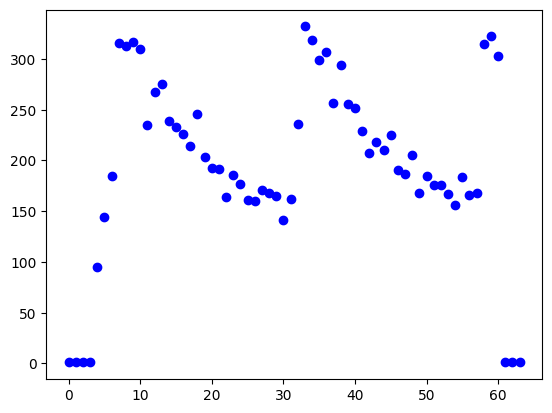

In [6]:
plt.plot(list(buffer), 'bo')
plt.show()

In [7]:
def init_fifo_measurement(tcspc, module_no):

    fifo_stopt_possible = True
    first_write = 1
    current_mode = 0

    # Disables the sequencer
    status, mod_no, enable = tcspc.SPC_enable_sequencer(module_no, 0)
    print(f'Enable sequencer status: {status} with mod_no: {mod_no} and enable: {enable}')

    status, mod_no, par_id, value = tcspc.SPC_get_parameter(module_no, 27, current_mode)
    print(f'Get parameter status: {status} with mod_no: {mod_no}, par_id: {par_id} and value: {value}')

    print(current_mode)

    # Sets MODE to 2 (FIFO mode)
    status, mod_no, par_id, value = tcspc.SPC_set_parameter(module_no, 27, 2)
    print(f'Set parameter status: {status} with mod_no: {mod_no}, par_id: {par_id} and value: {value}')

    status, mod_no, par_id, current_mode = tcspc.SPC_get_parameter(module_no, 27, current_mode)
    print(f'Get parameter status: {status} with mod_no: {mod_no}, par_id: {par_id} and value: {current_mode}')

    print(f'Current mode: {current_mode}')

    scan_polarity = 0
    rout_mode = 0

    # Get SCAN_POLARITY (not used in this case, only for scanning)
    status, mod_no, par_id, scan_polarity = tcspc.SPC_get_parameter(module_no, 32, scan_polarity)
    print(f'Get parameter status: {status} with mod_no: {mod_no}, par_id: {par_id} and value: {scan_polarity}')

    print(f'Scan polarity: {scan_polarity}')

    # Get ROUT_MODE (not used)
    status, mod_no, par_id, rout_mode = tcspc.SPC_get_parameter(module_no, 25, rout_mode)
    print(f'Get parameter status: {status} with mod_no: {mod_no}, par_id: {par_id} and value: {rout_mode}')

    print(f'Routing mode: {rout_mode}')

    # Sets STOP_ON_TIME to 0
    status, mod_no, par_id, value = tcspc.SPC_set_parameter(module_no, 18, 0)
    print(f'Set parameter status: {status} with mod_no: {mod_no}, par_id: {par_id} and value: {value}')

    # Sets STOP_ON_OVFL to 0
    status, mod_no, par_id, value = tcspc.SPC_set_parameter(module_no, 19, 0)
    print(f'Set parameter status: {status} with mod_no: {mod_no}, par_id: {par_id} and value: {value}')

    if fifo_stopt_possible:
        # If FIFO stop after coltime is possible 
        # Set STOP_ON_TIME to 1
        status, mod_no, par_id, value = tcspc.SPC_set_parameter(module_no, 18, 1)
        print(f'Set parameter status: {status} with mod_no: {mod_no}, par_id: {par_id} and value: {value}')

    max_words_in_buffer = 2 * 200000

    return max_words_in_buffer

In [8]:
def save_photons_in_file(filepath, FIFO_type, words_in_buf, data_buffer, first_write=True):

    no_of_fifo_routing_bits = 0

    first_frame = (c_ushort * 3)()

    ret, mod_no, fifo_type, stream_type, mt_clock, spc_header = tcspc.SPC_get_fifo_init_vars(module_no, None, None, None, None)
    print(f'Get fifo init vars status: {ret} with mod_no: {mod_no}, fifo_type: {fifo_type}, stream_type: {stream_type}, mt_clock: {mt_clock} and spc_header: {spc_header}')

    first_frame[0] = c_ushort(spc_header)
    first_frame[1] = c_ushort(spc_header >> 16)
    first_frame[2] = 0

    try:
        if first_write:
            # Open the file for writing in binary mode
            with open(filepath, "wb") as stream:
                # Write the first 2 words (32 bits) to the file
                stream.write(bytes(first_frame[:2]))

        # Write photons buffer to the file
        with open(filepath, "ab") as stream:
            ret = stream.write(bytes(data_buffer[:2 * words_in_buf]))

        if ret != 2 * words_in_buf:
            # Error occurred, return -1
            return -1

    except IOError:
        # Error occurred while opening the file, return -1
        return -1

    # No errors occurred, return 0
    return 0

In [10]:
max_words_in_buffer = init_fifo_measurement(tcspc, module_no)
fifo_stopt_possible = True
buffer = (c_ushort * max_words_in_buffer)()

photons_to_read = 10000

FIFO_type = 3 # FIFO 32

if FIFO_type == 3:
    words_to_read = 2 * photons_to_read

words_left = words_to_read
words_in_buf = 0

Enable sequencer status: 0 with mod_no: c_short(0) and enable: c_short(0)
Get parameter status: 0 with mod_no: c_short(0), par_id: c_short(27) and value: c_float(2.0)
0
Set parameter status: 0 with mod_no: c_short(0), par_id: c_short(27) and value: c_float(2.0)
Get parameter status: 0 with mod_no: c_short(0), par_id: c_short(27) and value: c_float(2.0)
Current mode: c_float(2.0)
Get parameter status: 0 with mod_no: c_short(0), par_id: c_short(32) and value: c_float(0.0)
Scan polarity: c_float(0.0)
Get parameter status: 0 with mod_no: c_short(0), par_id: c_short(25) and value: c_float(0.0)
Routing mode: c_float(0.0)
Set parameter status: 0 with mod_no: c_short(0), par_id: c_short(18) and value: c_float(0.0)
Set parameter status: 0 with mod_no: c_short(0), par_id: c_short(19) and value: c_float(0.0)
Set parameter status: 0 with mod_no: c_short(0), par_id: c_short(18) and value: c_float(1.0)


In [11]:
status, mod_no = tcspc.SPC_start_measurement(module_no)
print(f'Start measurement status: {status} with mod_no: {mod_no}')

continue_acquisition = True

while continue_acquisition:

    status = test_state(tcspc, module_no, True)

    if words_left > max_words_in_buffer - words_in_buf:
        # limit current_cnt to the free space in buffer
        current_cnt = max_words_in_buffer - words_in_buf
    else:
        current_cnt = words_left

    ptr = POINTER(c_ushort)(c_ushort(buffer[words_in_buf]))

    if 'SPC_ARMED' in status:
        if 'SPC_FEMPTY' in status:
            continue # Fifo is empty - nothing to read

        # before the call current_cnt contains required number of words to read from fifo
        ret, current_cnt, readed = tcspc.SPC_read_fifo(module_no, current_cnt, ptr)
        # after the call current_cnt contains number of words read from fifo
        print(f'Read FIFO status: {ret} with words read: {current_cnt}, ptr: {ptr}')

        words_left -= current_cnt

        if words_left == 0:
            # required no of photons read already
            continue_acquisition = False
            break

        if 'SPC_FOVFL' in status:
            # Fifo overrun occured
            # macro time information after the overrun is not consistent
            # consider to break the measurement and lower photon's rate
            print('FIFO overflow')
            continue_acquisition = False
            break
        # during the running measurement it is possible to check how occupied is FIFO
        # by calling SPC_get_fifo_usage function

        words_in_buf += current_cnt
        if words_in_buf == max_words_in_buffer:
            # your buffer is full, but photons are still needed
            # save buffer contents in the file and continue reading photons
            #ret = save_photons_in_file()
            words_in_buf = 0
    else:
        if fifo_stopt_possible and ('SPC_TIME_OVER' in status):
            # measurement stopped after collection time
            # read rest photons from the fifo
            # before the call current_cnt contains required number of words to read from fifo
            ret = tcspc.SPC_read_fifo(module_no, current_cnt, ptr)
            # after the call current_cnt contains number of words read from fifo
            print(f'Read FIFO status: {ret} with words read: {current_cnt}, ptr: {ptr}')
            words_left -= current_cnt
            words_in_buf += current_cnt
            break
    
status, mod_no = tcspc.SPC_stop_measurement(module_no)
print(f'Stop measurement status: {status} with mod_no: {mod_no}')

#if (words_in_buf > 0):
    # save the rest of photons in the buffer
#    ret = save_photons_in_file()



Start measurement status: 0 with mod_no: c_short(0)
Status code: ['SPC_ARMED']


ValueError: too many values to unpack (expected 3)

In [ ]:
ret, mod_no, fifo_type, stream_type, mt_clock, spc_header = tcspc.SPC_get_fifo_init_vars(module_no, FIFO_type, 0, None, None)
spc_file = 'test.spc'
what_to_read = 1
stream_handl, fifo_type, phot_fname, files_to_use, stream_type, what_to_read = tcspc.SPC_init_phot_stream(fifo_type, spc_file, 1, stream_type, what_to_read)
print(f'Init phot stream status: {stream_handl} with fifo_type: {fifo_type}, phot_fname: {phot_fname}, files_to_use: {files_to_use}, stream_type: {stream_type} and what_to_read: {what_to_read}')

if stream_handl >= 0:
    status, handle, stream_info = tcspc.SPC_get_phot_stream_info(stream_handl, PhotStreamInfo())
    print(f'Get phot stream info status: {status} with handle: {handle} and stream_info: {stream_info}')
    ret = 0
    while not ret:

        ret, handle, photon_info = tcspc.SPC_get_photon(stream_handl, PhotInfo())
        print(f'Get photon status: {ret} with handle: {handle} and photon_info: {photon_info}')

    status, handle, stream_info = tcspc.SPC_get_phot_stream_info(stream_handl, PhotStreamInfo())
    print(f'Get phot stream info status: {status} with handle: {handle} and stream_info: {stream_info}')

    status, handle = tcspc.SPC_close_phot_stream(stream_handl)
    print(f'Close phot stream status: {status} with handle: {handle}')